## Calculation of posterior error probabilities from $q$ values in high throughput experiments.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import math
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, general_gaussian
from sklearn.metrics import mean_absolute_error as mae

In [18]:
import pandas as pd
import gdown
import os

def load_tab_delimited_from_gdrive(gdrive_url, output_file='file.tsv'):
    """
    Downloads a tab-delimited file from Google Drive (if not already downloaded)
    and loads it into a pandas DataFrame.

    Parameters:
    gdrive_url (str): The shared link of the file on Google Drive.
    output_file (str): The name of the output file to save the downloaded content.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the data from the tab-delimited file.
    """
    # Check if the file already exists
    if not os.path.exists(output_file):
        # Extract the file ID from the Google Drive URL
        file_id = gdrive_url.split('/')[-2]
        
        # Create the download URL
        download_url = f'https://drive.google.com/uc?id={file_id}'
        
        # Download the file
        gdown.download(download_url, output_file, quiet=False)
    else:
        print(f"File '{output_file}' already exists. Loading from local file.")

    # Load the tab-delimited file into a DataFrame
    df = pd.read_csv(output_file, sep='\t', usecols=['percolator q-value', 'percolator PEP'])
    
    df.rename(columns={'percolator q-value': 'q', 'percolator PEP': 'PEP'}, inplace=True)

    return df

# Example usage:
gdrive_url = 'https://drive.google.com/file/d/1rfjPyQFcSuhoW93v3saIgngE7mnFbIs0/view?usp=sharing'
perc = load_tab_delimited_from_gdrive(gdrive_url)
# display(df)


File 'file.tsv' already exists. Loading from local file.


## We estimate the PEPs from the q-values:

$PEP_n= q_n * n - q_{n-1} * (n-1)$

For that purpose we create X: an array for each $q_n(i) * n(i)$

### Read data



In [19]:
perc["qn"] = perc["q"]*perc.index
qn=np.array(perc["qn"])

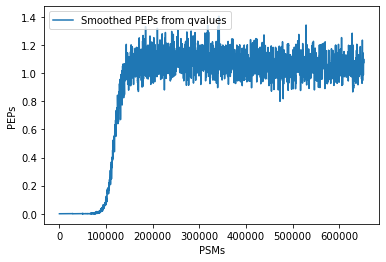

In [27]:
w = 1025
p = 3
pep_est = savgol_filter(qn, w, p, 1)
plt.plot(np.arange(1,pep_est.shape[0]+1), pep_est, label= "Smoothed PEPs from qvalues")
plt.legend(loc="upper left")
plt.xlabel("PSMs")
plt.ylabel("PEPs")
plt.show()


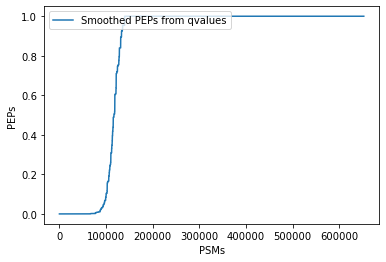

In [31]:
from sklearn.isotonic import IsotonicRegression

differences = np.diff(qn)

# Append an additional element (e.g., 0) to make the length equal to the original array
differences = np.append(differences, 1.0)  # You can use np.nan instead of 0 if you prefer

iso_reg = IsotonicRegression(y_max=1.0, y_min=0.0, increasing=True, out_of_bounds="clip")
pep_iso = iso_reg.fit_transform(np.arange(1,differences.shape[0]+1), differences)

plt.plot(np.arange(1,pep_iso.shape[0]+1), pep_iso, label= "Smoothed PEPs from qvalues")
plt.legend(loc="upper left")
plt.xlabel("PSMs")
plt.ylabel("PEPs")
plt.show()


## Analysis of results:

Considering that in equation(1):

$q_n= \sum_{i=1}^n (PEP_i/n)$

We can calculate again the q-values using our estimated PEPs.

Next, we plot in x-axis the original q-values calculated from the FDRs in percolator, and in y-axis the q-values obtained from our estimated PEPs. We use the log scale for a better visualization of the results. As we can see, the estimated PEPs yield similar q-values as the ones we originally obtained from Percolator. This proves that the recursive method is effective to estimate PEPs from q-values and could be implemented as an alternative method. 

We can evaluate the Pearson's and Spearman correlation coefficients, and the mean absolute error for better assessment of their relation:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


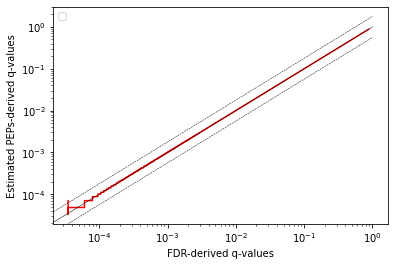

NameError: name 'qvalues_estimated' is not defined

In [29]:
perc["PEP_est"] = pep_est
perc["q_est"] = perc["PEP_est"].cumsum()/perc.index

a=np.linspace(0,1,100)
b=a/10**(0.25)
c=a*10**(0.25)
plt.plot(perc["q"], perc["q_est"], c="r")

plt.plot(a,b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a,c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a,a, c="k", linewidth=0.5)
plt.legend(loc="upper left")
plt.xlabel("FDR-derived q-values")
plt.ylabel("Estimated PEPs-derived q-values")
plt.yscale("log")
plt.xscale("log")

plt.show()

## Comparing to the non-parametric PEPs:

If we compare our estimated PEPs with the PEPs obtained from the non-parametrical method of Percolator we can see that the filter has difficulties to replicate the PEPs for the lowest values. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


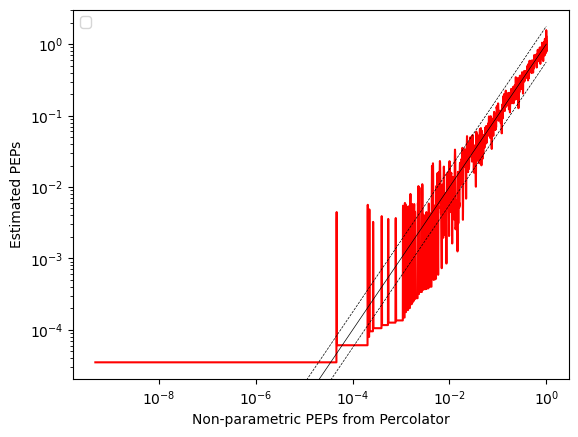

In [ ]:
a=np.linspace(0,1,100)
b=a/10**(0.25)
c=a*10**(0.25)
plt.plot(P, X_smooth_1, c="r")

plt.plot(a,b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a,c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a,a, c="k", linewidth=0.5)
plt.legend(loc="upper left")
plt.xlabel("Non-parametric PEPs from Percolator")
plt.ylabel("Estimated PEPs")
plt.yscale("log")
plt.xscale("log")

plt.show()


